In [1]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### Importing data

In [2]:
data = pd.read_csv('data/fra-eng/fra.tsv', delimiter='\t')
data.head()

,english,french
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !


##### Since the dataset has around 1,50,000 training examples but we will be using only 20,000 rows to keep it simple.

In [3]:
data = data.iloc[:20000, :]
train, test = train_test_split(data, test_size=0.2, random_state=42)

english = train.english.values
french = train.french.values

#### Exploring dataset

In [4]:
print("Length of english sentence ", len(english))
print("Length of french sentence ", len(french))
print('-'*20)
print(english[100])
print('-'*20)
print(french[100])

Length of english sentence  16000
Length of french sentence  16000
--------------------
I wasn't hired.
--------------------
On ne m'a pas recrutée.


#### Remove all punctuations from text

In [62]:
english = [s.translate(str.maketrans('', '', string.punctuation)) for s in english]
french = [s.translate(str.maketrans('', '', string.punctuation)) for s in french]

print(english[100])
print('-'*20)
print(french[100])

I wasnt hired
--------------------
On ne ma pas recrutée


#### Convert all examples to lowercase

In [63]:
english = [s.lower() if isinstance(s, str) else s for s in english]
french = [s.lower() if isinstance(s, str) else s for s in french]

print(english[100])
print('-'*20)
print(french[100])

i wasnt hired
--------------------
on ne ma pas recrutée


#### Visualise the length of examples

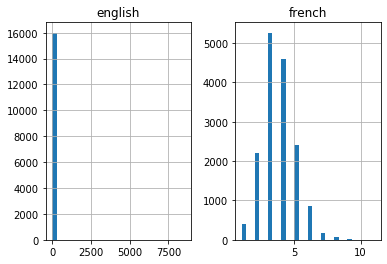

In [64]:
eng_l = [len(s.split()) for s in english]
fre_l = [len(s.split()) for s in french]

length_df = pd.DataFrame({'english': eng_l, 'french': fre_l})
length_df.hist(bins=30)
plt.show()

In [65]:
from keras import optimizers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, RepeatVector

In [66]:
def tokenizer(corpus):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    return tokenizer

english_tokenizer = tokenizer(english)
french_tokenizer = tokenizer(french)

word_index_english = english_tokenizer.word_index
word_index_french = french_tokenizer.word_index

eng_vocab_size = len(word_index_english) + 1
fre_vocab_size = len(word_index_french) + 1

In [67]:
print("Size of english vocab:", len(word_index_english))
print("Size of french vocab:", len(word_index_french))

Size of english vocab: 4820
Size of french vocab: 7011


In [68]:
max_len_eng = max(eng_l)
max_len_fre = max(fre_l)

print("Max length of english sentence:", max_len_eng)
print("Max length of french sentence:", max_len_fre)

Max length of english sentence: 8556
Max length of french sentence: 11


In [69]:
def encode_sequences(tokenizer, length, text):
    sequences = tokenizer.texts_to_sequences(text)
    sequences = pad_sequences(sequences, maxlen=length, padding='post')
    return sequences

In [70]:
eng_seq = encode_sequences(english_tokenizer, max_len_eng, english)
fre_seq = encode_sequences(french_tokenizer, max_len_fre, french)

print(eng_seq[10])
print(fre_seq[10])

[ 24 447 570 ...   0   0   0]
[  12  166 1588    0    0    0    0    0    0    0    0]


In [71]:
def nmt_model(in_vocab_size, out_vocab_size, in_timestep, out_timestep, units):
    model = Sequential()
    model.add(Embedding(in_vocab_size, units, input_length=in_timestep, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timestep))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab_size, activation="softmax"))
    return model

In [72]:
model = nmt_model(fre_vocab_size, eng_vocab_size, max_len_fre, max_len_eng, 256)

In [46]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=rms, metrics=['accuracy'])

In [47]:
fre_seq = fre_seq.reshape(fre_seq.shape[0], fre_seq.shape[1], 1)
history = model.fit(eng_seq, fre_seq, batch_size=512, epochs=5, verbose=1, validation_split=0.1)

/home/amarpandey/Jupyter Notebook/notebook/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9000 samples, validate on 1000 samples
Epoch 1/5
9000/9000 [==============================] - 35s 4ms/step - loss: 3.1625 - accuracy: 0.6838 - val_loss: 2.6155 - val_accuracy: 0.6601
Epoch 2/5
9000/9000 [==============================] - 33s 4ms/step - loss: 2.1775 - accuracy: 0.7039 - val_loss: 2.4606 - val_accuracy: 0.6612
Epoch 3/5
9000/9000 [==============================] - 30s 3ms/step - loss: 2.0271 - accuracy: 0.7110 - val_loss: 2.4417 - val_accuracy: 0.6606
Epoch 4/5
9000/9000 [==============================] - 28s 3ms/step - loss: 1.9618 - accuracy: 0.7158 - val_loss: 2.4130 - val_accuracy: 0.6686
Epoch 5/5
9000/9000 [==============================] - 29s 3ms/step - loss: 1.9012 - accuracy: 0.7219 - val_loss: 2.3788 - val_accuracy: 0.6728


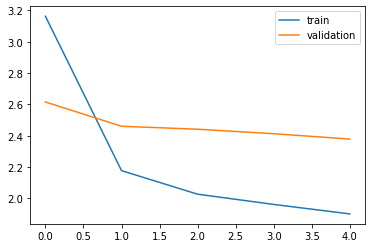

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()